In [146]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")

from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
print "width = %f, height = %f" % (width,height)
x_data = map( lambda x: x-width/2 , x_raw )
y_data = map( lambda x: x-height/2 , y_raw )
domain = (-width/2,width/2,-height/2,height/2)

width = 1980.000000, height = 1093.000000


In [147]:
from matplotlib import pyplot as plt
%matplotlib inline

In [148]:
theta = np.load('theta_opt_stat_mech.npy')

# Modified Hausdorff Distance

In [149]:
def modified_Hausdorff_distance(x_a, y_a, x_b, y_b):
    #computes the modified Hausdorff distance between two point sets.
    return max( mhd_helper(x_a, y_a, x_b, y_b) , mhd_helper(x_b, y_b, x_a, y_a) )

def mhd_helper(x_a, y_a, x_b, y_b):
    out = 0
    for x,y in zip(x_a,y_a):
        out += np.sqrt( np.min( (x_b - x)**2 + (y_b-y)**2 ) )
    out = out / len(x_a)
    return out

## Collocation

In [164]:
def get_vars( xy_int ):
    n = (len(xy_int))/2
    return xy_int[:n], xy_int[n:2*n]

def length( xy_int, x0, y0, xy, yf ):
    #computes the action of a curve
    global theta, width, height
    x_int, y_int = get_vars(xy_int)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    u = ( x[1:] - x[:n-1] )
    v = ( y[1:] - y[:n-1] )
    out = 0.5*np.dot(u,u) + 0.5*np.dot(v,v)
    return out
    
def jac_length(dec_vars, x0, y0, xy, yf ):
    #computes the jacobian of the action functional
    x_int, y_int = get_vars(xy_int)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    u = ( x[1:] - x[:n-1] )
    v = ( y[1:] - y[:n-1] )
    ax = u[:n-2] - u[1:]
    ay = v[:n-2] - v[1:]
    return np.hstack( [ax, ay])

def action( xy_int , x0, y0, xy, yf ):
    #computes the action of a curve
    global theta, width, height
    x_int, y_int = get_vars(xy_int)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    u = ( x[1:] - x[:n-1] )
    v = ( y[1:] - y[:n-1] )
    from numpy.polynomial.legendre import legval2d
    V = legval2d(2*x[1:n-1]/width, 2*y[1:n-1]/height, theta)
    out = 0.5*np.dot(u,u)
    out += 0.5*np.dot(v,v)
    out -= V.sum()
    return out

def EL_constraint( xy_int , x0, y0, xy, yf ):
    #this is also the jacobian of the action
    global theta, width, height
    x_int, y_int = get_vars(xy_int)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    ax = x[2:] + x[0:n-2] - 2*x[1:n-1]
    ay = y[2:] + y[0:n-2] - 2*y[1:n-1]
    from numpy.polynomial.legendre import legder, legval2d
    theta_x = legder( theta, m=1, axis=0)
    theta_y = legder( theta, m=1, axis=1)
    Vx = 2*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_x)/width
    Vy = 2*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_y)/height
    return -np.hstack([ax+Vx, ay+Vy])

def jac_EL( xy_int , x0, y0, xy, yf):
    #the jacobian of the EL constraint [ [A+Vxx, Vxy], [Vxy, A+Vyy] ]
    global theta, width, height
    x_int, y_int = get_vars(xy_int)
    x = np.hstack([x0,x_int,xf])
    y = np.hstack([y0,y_int,yf])
    n = len(x)
    from scipy import sparse
    diags = np.ones((3,n))
    diags[1,:] = -2*np.ones(n)
    A = sparse.dia_matrix( (diags, [-1,0,1]) , shape = (n-2,n-2))
    from numpy.polynomial.legendre import legder, legval2d
    theta_xx = legder( theta, m=2, axis=0)
    theta_yy = legder( theta, m=2, axis=1)
    theta_xy = legder( legder( theta, axis=0 ) , axis=1 )
    Vxx = 4*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_xx)/(width**2)
    Vxx = sparse.dia_matrix( ( Vxx, 0), shape=(n-2,n-2) )
    Vyy = 4*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_yy)/(height**2)
    Vyy = sparse.dia_matrix( ( Vyy, 0), shape=(n-2,n-2) )
    Vxy = 4*legval2d( 2*x[1:n-1]/width, 2*y[1:n-1]/height, theta_xy)/(width*height)
    Vxy = sparse.dia_matrix( ( Vxy, 0), shape=(n-2,n-2) )
    out = -sparse.vstack( [ sparse.hstack( [A+Vxx, Vxy] ) , sparse.hstack([Vxy, A+Vyy]) ] ) 
    return out.todense()
    
def callback(xy_int):
    print "Length = %f" % length(dec_vars)
    return 0

def get_optimal_curve(x_begin, y_begin, x_end, y_end, n_steps, guess=None):
    # computes the optimal curve which satisfies the dynamics.
    global action, EL_constraint
    if guess is None:
        x_guess = np.linspace(x_begin, x_end, n_steps)[1:n_steps-1]
        y_guess = np.linspace(y_begin, y_end, n_steps)[1:n_steps-1]
        guess = np.hstack([x_guess,y_guess])
    from scipy.optimize import minimize
    constraint_list = []
    constraint_list.append( {'type':'eq', 'fun':EL_constraint, 'args':(x_begin, y_begin, x_end, y_end),'jac':jac_EL})
    res = minimize( length, guess, jac = jac_length,
                   callback=callback, args=(x_begin,y_begin,x_end,y_end), method = 'SLSQP')
    print res.message
    x,y,epsilon = get_vars( res.x )
    x = np.hstack([x_begin, x, x_end])
    y = np.hstack([y_begin, y, y_end])
    return x,y

In [165]:

x0 = np.random.randn()*width/4
xf = np.random.randn()*width/4
y0 = np.random.randn()*height/4
yf = np.random.randn()*height/4

x = np.random.randn(100) #np.linspace(x0, xf, 102)
y = np.random.randn(100)#np.linspace(y0, yf, 102)
xy_int = np.hstack( [ x, y] )
pert = np.random.randn(len(xy_int))*1e-6
print "perturbation size = %.4g" % np.abs(pert).max()
error = length(xy_int+pert, x0, y0, xf, yf) - length(xy_int, x0, y0, xf, yf) \
    - np.dot( jac_length(xy_int, x0, y0, xf, yf) , pert )

print "testing jacobian for length"
print "error = %.4g" % error

print "testing jacobian of action"
error = action( xy_int+pert, x0, y0, xf, yf) - action(xy_int, x0, y0, xf, yf) \
    - np.dot( EL_constraint(xy_int, x0, y0, xf, yf), pert)
print "error = %.4g" % error

print "testing jacobian of EL constraint"
A = ( EL_constraint(xy_int+pert, x0, y0, xf, yf) - EL_constraint(xy_int, x0, y0, xf, yf) )
B = jac_EL(xy_int, x0, y0, xf, yf).dot(pert)
print "error = %0.4g" % np.abs(A-B).max()

perturbation size = 3.118e-06
testing jacobian for length
error = 1.944e-10
testing jacobian of action
error = 1.853e-10
testing jacobian of EL constraint
error = 1.819e-14


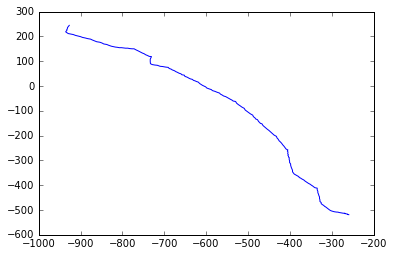

In [162]:
curve_ind = 20
plt.plot(x_data[curve_ind], y_data[curve_ind])

In [166]:
n_steps = len( x_data[curve_ind])
x_begin = x_data[curve_ind][0]
y_begin = y_data[curve_ind][0]
x_end = x_data[curve_ind][-1]
y_end = y_data[curve_ind][-1]

x_pred,y_pred = get_optimal_curve( x_begin, y_begin, x_end, y_end, n_steps )

error: failed in converting 8th argument `g' of _slsqp.slsqp to C/Fortran array